# Exercise 5 [Direct Transcription Methods]

In [3]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
import itertools

import cvxopt

# Using a quadratic program solver

In this exercise we will learn how to use a QP solver to solve LQ problems as in the model predictive control scheme presented in the class. Here we will use the quadratic program solver from cvxopt (https://cvxopt.org/). The installation instructions for the solver can be found here: https://cvxopt.org/install/index.html

A tutorial on how to use the QP solver can be found here: https://cvxopt.org/examples/tutorial/qp.html

And the function definition to use the QP solver can be found here: https://cvxopt.org/userguide/coneprog.html#quadratic-programming

As a first example, we see how a simple QP can be solved. Consider the following Quadratic Program
$$\min_x \frac{1}{2} x^T \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix} x + \begin{bmatrix} -1 \\ -1 \end{bmatrix}^T x$$
subject to: $$ x_i > 0 \qquad \forall x_i$$
and
$$ \begin{bmatrix} 1 \\ 1 \end{bmatrix}^T x = 1$$

The first constraint just says that each element of $x$ needs to be positive and the second constraint says that the sum of the elements of $x$ needs to be equal to 1. Below is a way to use cvxopt to solve the problem.

In [4]:
# the qp solve of cvxopt accepts problems of the form 0.5 xT P x + qT x, subject to Gx <= h, Ax=b
# in our case we have
P = np.array([[1.,0],[0,1]]) # be careful to write 1. instead of 1 in Python 2.0
q = np.array([[-1.],[-1.]])
G = np.array([[-1.,0],[0,-1.]])
h = np.array([[0.],[0]])
A = np.array([[1.,1]])
b = np.array([[1.]])

# we need to convert numpy arrays into the matrix structures understood by cvxopt
# you could also construct directly matrix objects without passing through numpy 
# here we demonstrate how to go from numpy to cvxopt.matrix because we have used numpy arrays thus far
P = cvxopt.matrix(P)
q = cvxopt.matrix(q)
G = cvxopt.matrix(G)
h = cvxopt.matrix(h)
A = cvxopt.matrix(A)
b = cvxopt.matrix(b)

# now we can just solve the qp by calling the qp function from cvxopt
sol = cvxopt.solvers.qp(P,q,G,h,A,b)
# we convert the solution as a numpy array back
x = np.array(sol['x'])

print('The solution of the problem is x=')
print(x)

     pcost       dcost       gap    pres   dres
 0: -7.5000e-01 -1.7500e+00  1e+00  0e+00  2e+00
 1: -7.5000e-01 -7.6000e-01  1e-02  2e-16  2e-02
 2: -7.5000e-01 -7.5010e-01  1e-04  3e-16  1e-04
 3: -7.5000e-01 -7.5000e-01  1e-06  0e+00  2e-06
 4: -7.5000e-01 -7.5000e-01  1e-08  0e+00  2e-08
Optimal solution found.
The solution of the problem is x=
[[0.5]
 [0.5]]


If we wanted to solve the same problem without the constraint that the sum of the vector components should be equal to 1, we could do it simply by omiting the A and b inputs

In [5]:
# now we can just solve the qp by calling the qp function from cvxopt
sol = cvxopt.solvers.qp(P,q,G,h)
# we convert the solution as a numpy array back
x = np.array(sol['x'])

#print('The solution of the problem is x=')
#print(x)

     pcost       dcost       gap    pres   dres
 0: -7.5000e-01 -1.7500e+00  1e+00  0e+00  1e+00
 1: -9.4382e-01 -9.5908e-01  2e-02  2e-16  2e-01
 2: -1.0000e+00 -1.0018e+00  2e-03  0e+00  6e-17
 3: -1.0000e+00 -1.0000e+00  2e-05  0e+00  2e-17
 4: -1.0000e+00 -1.0000e+00  2e-07  3e-16  9e-17
Optimal solution found.


In [6]:
def animate_car(x, goal):
    """
    This function makes an animation showing the behavior of the car
    takes as input the result of the solve_direct_transcription function 
    and the desired goal (x,y position)
    """
    
    #subsample
    plotx = x[:,:]
    
    fig = matplotlib.figure.Figure(figsize=[8,8])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-2,5.5], ylim=[-2,5.5])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'ob', lw=2)
    list_of_lines.append(line)
    
    car_length = 0.05
    car_height = 0.05
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - car_length
        x_front = plotx[0,i] + car_length
        y_up = plotx[2,i] + car_height
        y_down = plotx[2,i] - car_height
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([goal[0],goal[0]],[goal[1],goal[1]])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=100, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Direct transcription for the car model

Consider a 2 dimensional car model
$$ x_{n+1} = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & \Delta t \\ 0 & 0 & 0 & 1 \end{bmatrix} x_n + \begin{bmatrix} 0 & 0\\ \Delta t & 0 \\ 0 & 0 \\ 0 & \Delta t \end{bmatrix} u_n$$

where the first element of $x_n$ is the car horizontal position, the second element is the horizontal velocity, the third element the vertical position and the last element the vertical velocity. $u_n$ contains the horizontal and vertical acceleration as control inputs.

We would like to get the car from initial position (0,0) to the final goal (5,2) with 0 desired final velocities under the constraints that the maximum acceleration is limited to 5 in each direction. Here we will use $\Delta t = 0.1$ and an horizon length of 100 steps.

## Question 1
Write an optimal control problem (i.e. with a cost and constraints) that could find the desired behavior for the car  (you may encode the desired goal in the cost function).

## Question 2
We would like to solve the problem using the transcription method shown in the class. 
1. Write a function that finds a  solution to the problem (i.e. a control trajectory and the associated car states).
2. Find weights in your cost function such that the behavior resembles a  bang-bang controller (i.e. minimum time). Plot the resulting control input and state trajectory and use the animation function below to make a movie of the behavior
3. Find weights that reduce the bang bang behavior smoother. As before, plot states and controls and show an animation

## Question 3
Now assume that we add an additional constraint saying that at all times, the sum of the horizontal and vertical velocities of the car cannot be greated than 1. 
1. Write the new optimal control problem.
2. Write a novel function that solves this new problem.
3. How do the trajectories change compared to the case without the constraint? Analyze the resulting behavior, could you have found it manually? (as before, plot trajectories and show an animation)


## Question 2

In [8]:
def solve_direct_transcription(A,B,Q,R,x0,horizon_length, u_len ,u_max, x_des):
    """
    Here we want to find the optimal control path using a direct transcription approach
    
    Inputs: 
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    x_des: the desired goal position
    u_max: the maximum acceleration
    horizon_length: the number of steps
    
    returns: the state and control trajectories
    """    
    
    # the lenght of the state vector for the full trajectory is
    num_states = x0.size*horizon_length
    # the length of the control vector for the full trajectory is
    num_control = u_len*horizon_length
    # the total number of variables is
    num_vars = num_states + num_control

    Qtilde = np.zeros([num_vars, num_vars])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    btilde[0:x0.size] = -A.dot(x0)
    
    qtilde = np.zeros([num_vars])
    for i in range(horizon_length):
        Qtilde[x0.size * i:x0.size * (i + 1), x0.size * i:x0.size * (i + 1)] = Q
        Qtilde[num_states + u_len * i:num_states + u_len * (i + 1), 
               num_states + u_len * i:num_states + u_len * (i + 1)] = R
        qtilde[i * x0.size:(i + 1) * x0.size] = -x_des[:, i].dot(Q)
        Atilde[x0.size * i:x0.size * (i + 1), num_states + u_len * i:num_states + u_len * (i + 1)] = B

        if i > 0:
            Atilde[x0.size * i:x0.size * (i + 1), x0.size * (i - 1):x0.size * (i + 1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size * i:x0.size * (i + 1), x0.size * i:x0.size * (i + 1)] = -np.eye(x0.size)
    
    # we transform numpy arrays into cvxopt compatible matrices
    P = cvxopt.matrix(Qtilde)
    q = cvxopt.matrix(qtilde)
                    
    A = cvxopt.matrix(Atilde)
    b = cvxopt.matrix(btilde)

    # max acceleration
    G = np.zeros([2*num_control,num_vars])
    G[:,num_states:] = np.vstack((np.eye(u_len*horizon_length),-np.eye(u_len*horizon_length)))
    h = np.vstack((np.tile(u_max,u_len*horizon_length),np.tile(u_max,u_len*horizon_length))).flatten()
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)

    
    
    
    
    # once the problem is constructed we can call the solver
    sol = cvxopt.solvers.qp(P,q,G,h,A,b)
    x = np.array(sol['x'])
    
    ## we assume that the problem was constructed with the states first (x0,x1,...)
    ## and then the control inputs (u0, u1, ...)
    
    # we extract the control trajectory as a 2 * horizon_length array
    u = (x[num_states:].reshape(horizon_length,2)).transpose()
    
    # we extract the state trajectory and add the initial condition
    x = x[0:num_states]
    x = np.vstack((x0, x.reshape([horizon_length, x0.size]))).transpose()

    return x, u

     pcost       dcost       gap    pres   dres
 0: -1.3915e+06 -1.5162e+06  2e+06  1e+01  1e-16
 1: -1.3797e+06 -1.5105e+06  8e+05  5e+00  1e-16
 2: -1.3692e+06 -1.4946e+06  5e+05  3e+00  1e-16
 3: -1.3577e+06 -1.4670e+06  3e+05  1e+00  2e-16
 4: -1.3476e+06 -1.4337e+06  2e+05  6e-01  1e-16
 5: -1.3412e+06 -1.4045e+06  1e+05  3e-01  1e-16
 6: -1.3364e+06 -1.3709e+06  5e+04  1e-01  2e-16
 7: -1.3341e+06 -1.3507e+06  2e+04  4e-02  1e-16
 8: -1.3337e+06 -1.3354e+06  2e+03  3e-03  1e-16
 9: -1.3338e+06 -1.3339e+06  2e+02  2e-04  1e-16
10: -1.3338e+06 -1.3338e+06  1e+01  2e-05  1e-16
11: -1.3338e+06 -1.3338e+06  5e-01  6e-07  1e-16
12: -1.3338e+06 -1.3338e+06  1e-02  8e-09  1e-16
Optimal solution found.


<IPython.core.display.Javascript object>


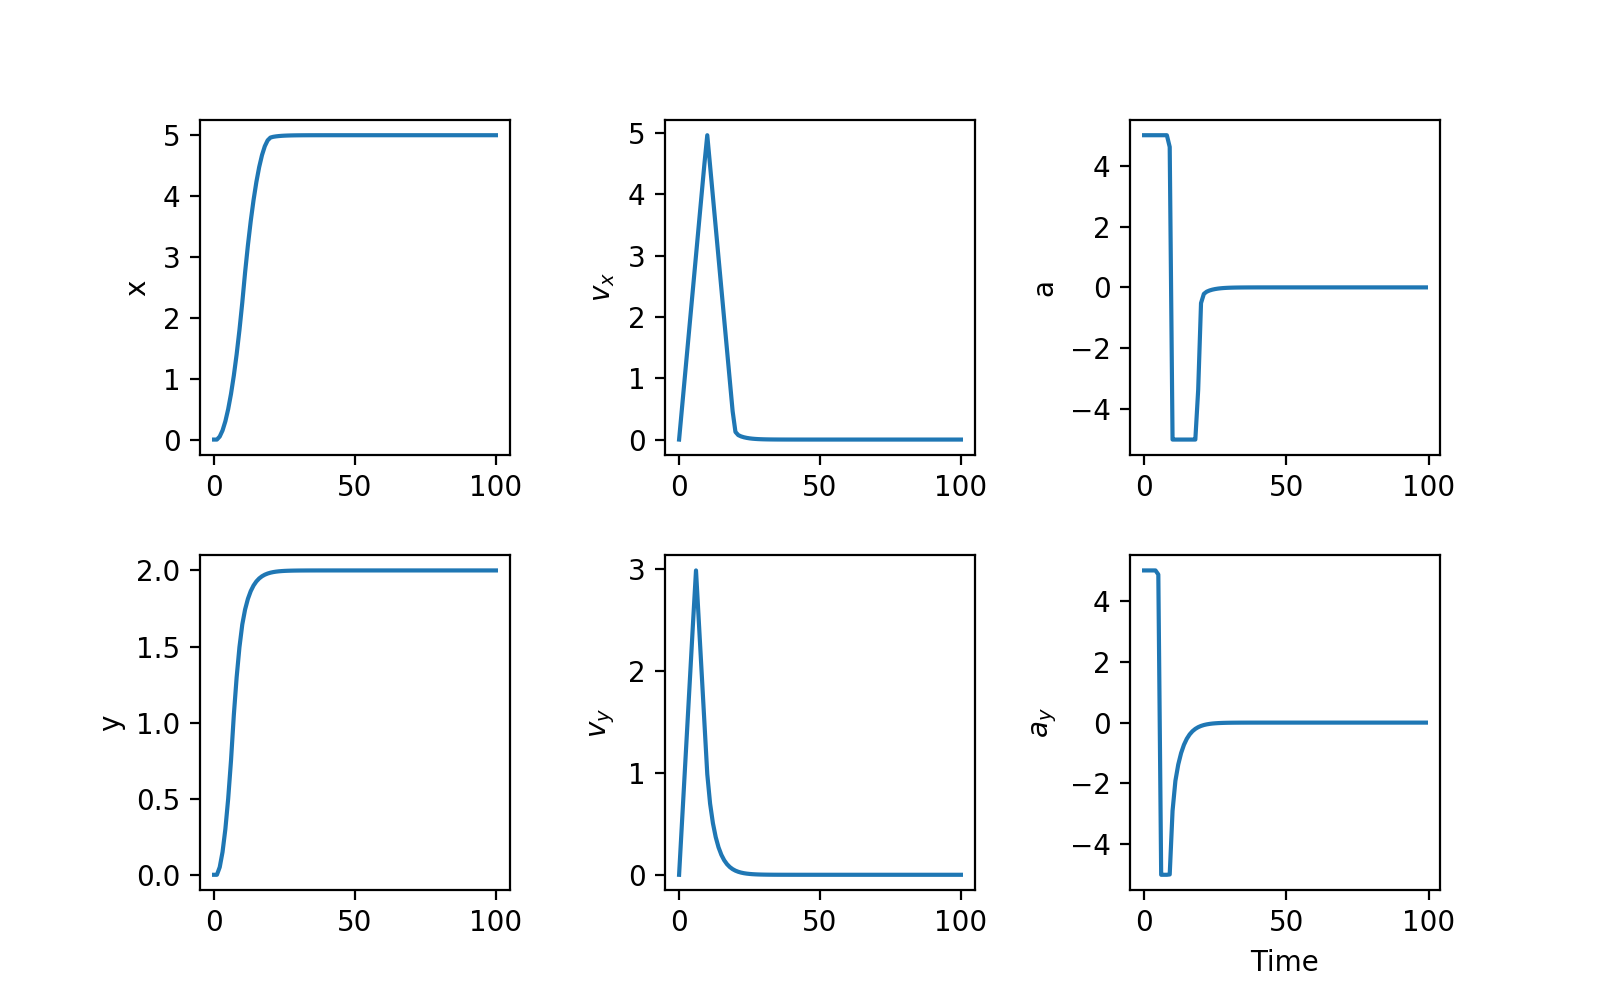

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAvd21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAARnmWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADADo2G98f8mU66joAAAMAB6gB
TAFKAhzn/w819xKfRBpZpsc5jvpRT+AD1Mb3QAzA1AtnA9BH4dIGZOIWBKDdx+XYE/Mc2VpnjOME
1bLOjIRBi/9XPIJIO//6sF/9SdKgpMpby2Am2qnx/b7k/jzCJTsds8/YK5wi4lV9V+6Lyl1lFBPw
a5Fep05dsNAk8WXE4j2YufyYFoHL+6ypE/kDQ6ek0EXMRj+6fRNi+Dd20/Sk/5m+k6LxWWueZJwG
cLruPjZLchMmabdEYCrEmPmhbtDzTgwxZD14xYMmci+yBKuvEFh2CtUHI/h6xON/FzO/1u8zc//+
KfJ4OUJ0LTBPTsIRbVh2e+WYAaUr/6Wacw2zit+gi0ykjR1CKRMmdr0QzS8qPOtF/liqA8Rq902E
rL9AoUVOHcwWnBkWTSNEwt59z+cUMakW6Mk/uTazmgIZX+pRArE0ZgUlQf1+fD2t+NDZoAoKPfGn
8YZUKWq9Wq+pFmCk9R0ArUICpMXL5LIicltL9PrAEw2i/MEvq3/NvU5nj4nAaTgRqs1QvuK74GSv
Xl+Xl+EnDVVRHm7N/5vQc+qcaI6IAk/4sVUEq06QxLQDjvDQAcR4eQgQrxHA/FV+jrAP+pVGzWcw
Y3U+G5v2kElRN8DYBFR1+bMK8//mtIiVohP/SU/oEr7yl4jn0A7j1Nq3mt/BJC8CDFfnyp9whGXt
6hxd4a+G/M5JSTsx9HSgGNfEGCHhUD8L/IuWqtQ8phRBC4MwqyZKMrda5rMLYIKgmVSvj8lBvEQh
zMC95xfBa9YACNFgAAkgAB1gAnQXobpGd5WCSYpw0upeEXM/XEkiFX9gjXMz46bBQ7xRK/8ELIkW
FtdMi/m2bmhkt2b1svB+hrfMJbosi7dJspYH/4qug8bUGl9lb/M8SzYyWpFDoRQRhjvyBXwzVeII
tYLb0Zzys4lPQ5z8VqRTinCFJn5pWoTG7aIp+pZ+fHJYPd8zKNb6ThcYLT5ydS/g0D6vZ4QML6oz
fRBpTfGT8ACfmnhy+OnGgF9Pf7whqRgbVpzX5/vt6jo1E6CpqdUODg78pCeAc2jakStsGScJseW8
g9VA82KRSU4jzRB6W5gUoBI4Q7IRG6AomcvfdFcsHYj6m8i58OQxglLPlriiYKqjy/qKL7c/5Ohw
vo65ObvrDS+4ZxqYR7m8HMt+4afstginANQGoQcCYVP7UJb3cm7fHTOUu96PXsNxwM/038oNVe7d
1LLrCxBFBUBbjsGcP7tVWcCVH+Xqzyw4puS6Nl6GH9ROQpiO+ISDNz0sq66Yn4IN4rUamWZV91As
ub/BeL4K5F9O71KrLlyVFWduxWC6JGmQSLD+Z6gAACvHXi2jPbt+vHQAC+gfJAbABTop70Eg/MQn
gDL+TX9/wcN/aDJcPRZhxZ885SFeSmUndf79GowO6SnGf3WnmfALMOgh4uLWHke93BNT2LV3BD1o
WOarBs9vRD0ns+yPfGRHWQnMJ4yOcaBuYqA0y/sPplDD9RVsjxhIUOc1QRZCqyeXjGS67o0miYZC
YdAmJPs6vtMM7V8ukVZOKkh5UGCGgacaSB26S++ZXT8vJRVUnQT7myVPee8peI59ATFe555/J7GC
/OsYRaVZvfIs0E2NXBp/VRCXxk4S8bHtxbFZmEPCoH4YixPbQJmBW/hWuDMKsmSe+7zhcMEOQp9U
DCxdCmGQWKm0m9FfbiTzT0lLvOmYqhBw0flY94VeUBRUQtVdP0Car/Tpn+5eRrRS5q4EolDZS/D2
lF8WAS8SfD9cyDXHo/WBtMZbeXKjeJSuAMcchnxzU2sZ/CI418LzS7d9B6QTY3jjXeBAQQgD7XNl
B81elM8QV/l7f+7Z8vBFEy2PSCdEyLTQ+gXnnoz68gCLC7YRjFk02LihQNZYdiFhvKNqf5mS9B2D
Bn2tFRykvr1gnqlxOabNBeRAIebNeCHLY/UL/0DKiPF8aTX1rJOFW2di4dkWhUVVNU/Gq+a6NoVY
W8MztE/VmKuo7Rjavy+nXvq/P8z4ZkKccKiSOdL8FL2kRYYOM5WXU4MWPO0q8qy9iZc+jcJD0D73
AXeMCietKMA8+aSVYeEbdJGb+I07V/E7XeImQq/EAbUaqjVOW0i6FhjfyvwWT0iHDsszpEWGMV5u
UlT9rYohzoiOk4MzVCKsUYH6w2De5RtAf9ibJ57OY1DrLC2Fowov787oYxdZ22XPpPAyAvK/7d6Z
qGQtoLOEyvl4PnTGIAdfcUqXFcMAV4gEKOiAAEi2Ytwo1COv1dcyD9VRY14HIpEPNiGYGTcvQlx3
H9//uCiZAvhvkv/DKxiUZPBhrXvqT4qpVaEB6blrCk/NYbEkK2WBbOmvQCvvlTvelXn030fnyq8y
ShLTcpJ3K2ahyb/IruNsDvaQR9ELOjY0olKVo6PBqqsQjWdVdDjeoyIloUR6FueBt7UjWn+5O7B+
ndt6+xjLjal2luwM6GDWvKAJqWM+5ChWEtcLj0Lswi3Dw9eia98Wv5oY3uop0Fokf6im0HYQCYJT
Ak39EMCOewT7BOkZMNCug/WXu5MNiMtjEWVqyUUnALB4pRd79qvvKH6uuGCL+pD9rfzrsjPa0QO5
ajQNijN7qbL5+lftKh/GHLIkctBZIkGgFMJq3tKgiFTwLi6GuLZEcprAmdDZpKt7jHCmdMZmKD8j
zZGpMM2TqLmgSxVNPmmbJC3uKuu4erGqS90Ms7TKXZmd42TgywxrpgYXkgkFh/sESMsuEc1d8hrB
inTIFA3TajInPopIr/rN7yHNfsC/M6woSjgJyyVUoFNbOwdKus82IFj2EX/HW2r2GV5oTva4XF/K
Rdp73iQvXEqCQNxaznbBh

In [14]:
# weights to get a bang-bang type solution (max acceleration and then min acceleration)    
# we put more weight on positions than on velocities to allow the system high velocities
u_max = 5.
Q = np.array([[1000., 0., 0., 0.], [0., 100., 0., 0.], [0., 0., 1000., 0.], [0., 0., 0., 100.]])
R = np.array([[0.1, 0.], [0., 0.1]])
dt = 0.1
horizon_length=100

# initial condition
x0 = np.array([0.,0.,0.,0.])

# dynamics
A = np.array([[1.,dt,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,dt],[0.,0.,0.,1.]])
B = np.array([[0.,0.],[dt,0.],[0.,0.],[0.,dt]])
u_len = 2

# goal
des=np.array([[5],[0],[2],[0]])
x_des = np.tile(des,horizon_length)
x,u = solve_direct_transcription(A,B,Q,R,x0,horizon_length, u_len, u_max, x_des)


plt.figure(figsize=(8,5))
plt.subplots_adjust(wspace =0.5, hspace =0.3)
plt.subplot(2,3,1)
plt.plot(x[0,:])
plt.ylabel('x')
plt.subplot(2,3,2)
plt.plot(x[1,:])
plt.ylabel('$v_x$')
plt.subplot(2,3,3)
plt.plot(u[0,:])
plt.ylabel('a')
plt.subplot(2,3,4)
plt.plot(x[2,:])
plt.ylabel('y')
plt.subplot(2,3,5)
plt.plot(x[3,:])
plt.ylabel(r'$v_y$')
plt.subplot(2,3,6)
plt.plot(u[1,:])
plt.ylabel(r'$a_y$')
plt.xlabel('Time')
animate_car(x,(5,2)) 

     pcost       dcost       gap    pres   dres
 0: -1.1988e+03 -9.0384e+03  8e+03  9e-14  2e-16
 1: -1.2192e+03 -1.5651e+03  3e+02  3e-14  3e-16
 2: -1.2232e+03 -1.2364e+03  1e+01  8e-15  2e-16
 3: -1.2237e+03 -1.2241e+03  4e-01  4e-15  2e-16
 4: -1.2237e+03 -1.2237e+03  1e-02  3e-15  2e-16
 5: -1.2237e+03 -1.2237e+03  2e-04  3e-15  2e-16
Optimal solution found.


<IPython.core.display.Javascript object>


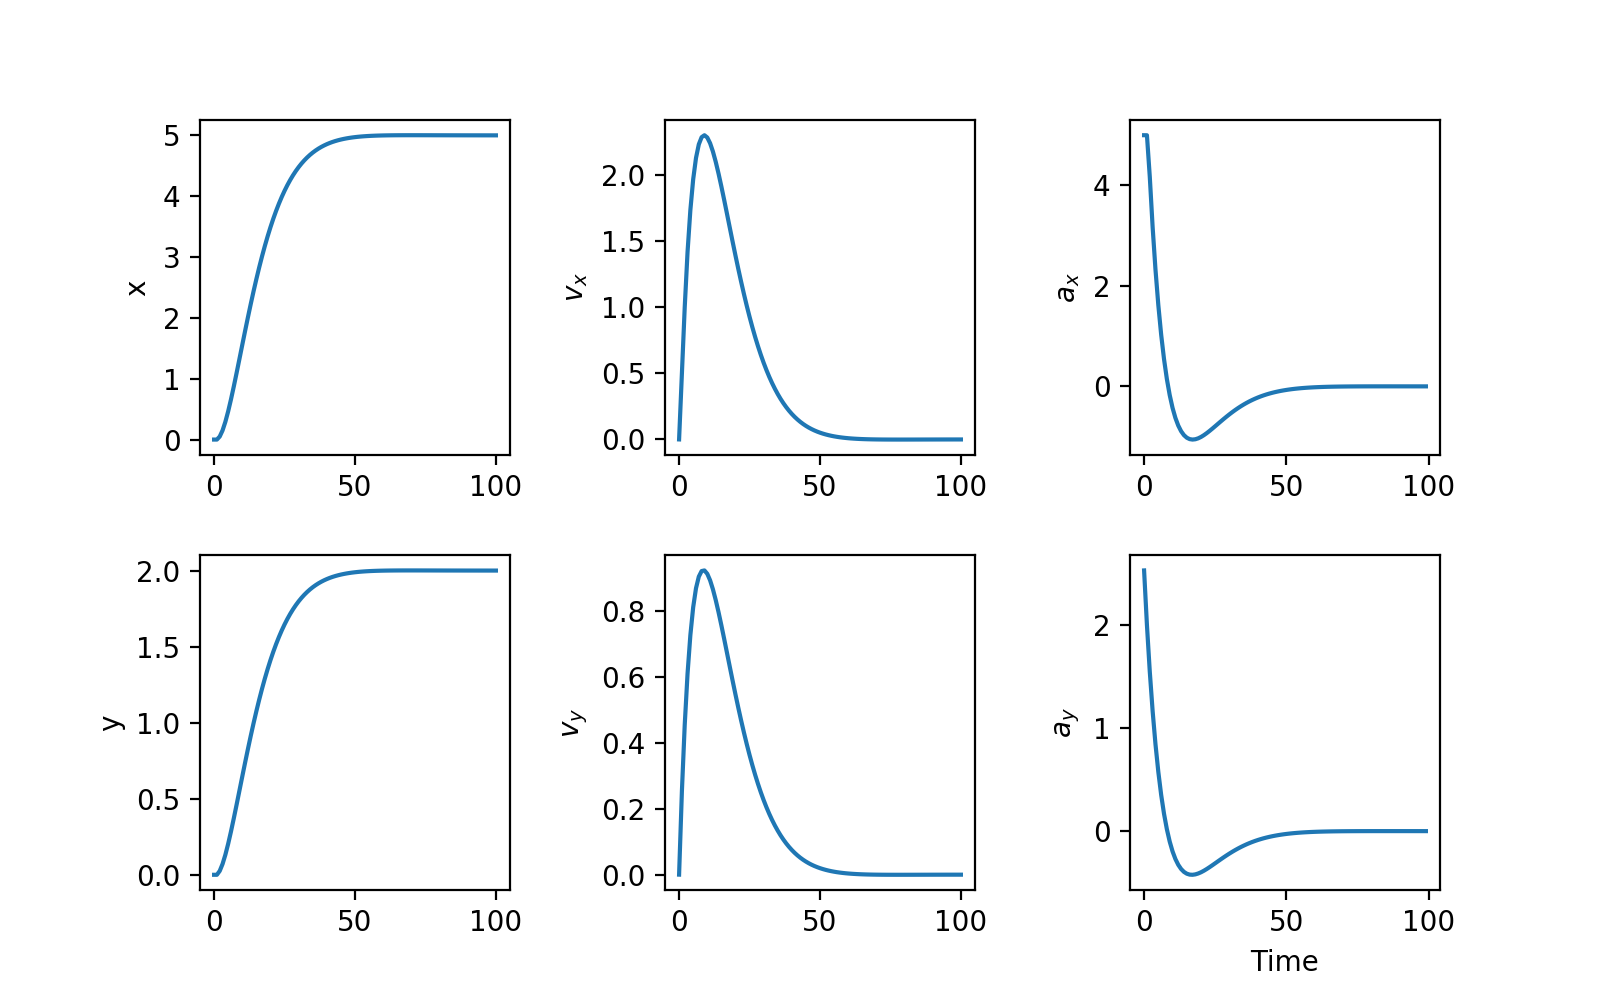

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAvyW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAARVWWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADADo2G98f8mU66joAAAMAB6gB
TAFKAhzn/w819xKfRBpZpsc5jvpRT+AD1Mb3QAzA1AtnA9BH4dIGZOIWBKDdx+XYE/Mc2VpnjOME
1bLOjIRBi/9XPIJIO//6sF/9SdKgpMpby2Am2qnx/b7k/jzCJTsds8/YK5wi4lV9V+6Lyl1lFBPw
a5Fep05dsNAk8WXE4j2YufyYFoHL+6ypE/kDQ6ek0EXMRj+6fRNi+Dd20/Sk/5m+k6LxWWueZJwG
cLruPjZLchMmabdEYCrEmPmhbtDzTgwxZD14xYMmci+yBKuvEFh2CtUHI/h6xON/FzO/1u8zc//+
KfJ4OUJ0LTBPTsIRbVh2e+WYAaTz/6WaOTCd0yevC0ykjB1CKQcmdr0QzS8qPOtF/liqA8Rq902E
rL9AoUVOHcwWnBkWTSNEwt59z+cUMakW6Mk/uTazmgIZX+pRArE0ZgUlQf1+fD2t+NDZoAoKPfGn
8YZUKWq9Wq+pFmCk9R0ArUICpMXL5LIicltL9PrAEw2i/MEvq3/NvU5nj4nAaTgRqs1QvuK74GSv
Xl+Xl9oE2kKeTKuvP/FiqglWnSCiCKHSJgpvkhYZzDSLDGTV53RXjxCP/qVRs1nMGN1N6bOzP4jK
g8w2ARUdfmzCvRLYa1llqvbG3BeW32BxP55S8Rz6Acs7EphdujmiCJtLneliedmAgKZVy4u8NfDe
xx7V+668INO1VNof+yIuPfT1NQ6FrLTUp9k9uMWYWTJRX67XNZhbBBIriqU/3pZhdu4/PVloinzH
cDLbA53NkbAwGHOVAAADAAADAAANQAE/nPAEBCB+YGNUczFTlEr2OugZaQjx02Ch3iiUB/b8fNXh
YTkMd9M4cy5yulJsNXcZTqfpZSUvWmoYU0D/8VXQeNqDS+yt/liH3sZLUih0IoIxF35Ar4ZqvEEW
sFt8Z2/B4HFSqafitSKcUpkpM/NK1CY2kJFP1LK+45LB7wAXPo0VGTBi0wsTliZXQ5SN1+97ryu3
JUO887XYtqPzTw5djTjQD1jWtaD/nHADWl5QH0URyuYCkxM1ptfQfPz7HVtbpaKfa2UJwmwRbxHF
S5+7/ssTiPMe/rQ3/nYCRwh2QiN0A1ryw+uebGZhP7B/sMPckzT5cagwUFfCjEt+5iVKX0URyuRJ
Hk0TiNtmYMtau6JFkK2wZJwmwZi+toKL/qv345t+cjxiGXHu6x1iyUAdjwMQ6fmf8+XIqsS6WmSx
40LQVAb46/Iy4IWMb6Sdhm4w/G1CdyXJ1p42x3lVtyGD1L7a65HfaGHOaBBu4AzbQ5+YXCNq3hyH
1zY6cYL3/Q4eAPAy6kCQEdw4gAAACfiOwFSac16ADMNp1xL1SLgApBOuVCPTzjTgBhV5Fmm0L4OG
/tBkuGWCw4s+ecpCvJTKTvYSlOPuPG/u0iVhwz/h02HEA8XFrDyPe7ffo7Fq7gh60LHNVg2NyR2G
9CST+kxuGYF1gbVTyy+QNzFQFpM8/SaJYfqKtlZJtxg4G4WUU5ho0PL+1HdGkxfDKtDoExrvMLnO
542Iy6RVk4qSHlSmlXqD8NmypgELrien5eSqdXzy+ao7tnlrgI59ATkDrHghXzqh4hy2cf2hGAct
rMIGvysKJCUQRXGw7fN/ayWe6EPCoH4YgZLb46A+b2YqwU0qYML8vkd0jzYd3EBbgOg4NdCmEKQn
FGeUEkR8f3s7is2FlKhiqwb4XtakjNR5kIzzsaLIUrKzPvLKDDRFvbsXMdX7qqHup4mLhW/FpBU5
iwAhtPHUzIDayixtHhhyZkAQHuLdemfx2ExD4ZKpgAAAAwAAAwFQDFk/4lEIFFSd/wXSJZMOCBby
F4CNvNUaS6tsqJdAM/NCTd2lE1F/kl8hRhP8fD8bCAvN5yCuZQSqj1hqDWY46mB0GEXhxpB7SkCX
/UMVcnCF5OmqT8vu6mqfkAmIwkDYP7dbtRWApaHmfLDrlnDzpgiZ6B7P/ywjw2Ha+QQmS0LgqH4h
CRZEI7G/jd0lT/XKPk9L6HIUYzvp60AXgXpL7fE/dCv/hbncVIu9JgZLVX26ZZ6hlvSo5wvvwQ31
BkeESzlW04fklBef1JE6XlAotauafJMbY9yhxca99jkfXYAgI1uOcTFv7MwMx2jvJSAPf84uROls
VD5+Jp7j0YUX9+d0MYus7bLn0ngZAXlf9u9M1DIW0FnCZXy8Hzpg39sOXL2r3N4r5xyWjFEfRUz0
mB4wEx7jghZCEY9liD/GRCuRZGZIq9icMl+O/254MaaDIFprZB/2hWNhgRrYVC0fZOEewj3jvIEL
s11fatDmcBjzvEZycNmPowKPgND4NfNzSt5L/3E0e84DvlAlhXp2qLTcOr/I+hfxs9cvM9nanN+9
xbWLzQMwEQ8yOhyrceLGzES45BK3QVrwm/F0bjndFSeCt7LcoAPSsUReFMboqTSCJMIyGlc1IlrF
LecflWjG58PD1Ij6dlVp9pEttStE3QbnS2z5ojZjuI4G2cUhu0bStM44pTveVmfM4Ebw/Jzu5yLQ
Ri4WCJoUyHjC/ot7RaIX7oPPsjOwEp+cG2mjEJGH149IshsYf+oyunbu/tKEt3p773P5YF16vc/M
l0bQAAADAXXAAABT7HKdGjGsRYqVM3bxEdGFmEsjuaBLFU0+aZskLd3mAAY6qP+7XVN5XrjfKr2p
TnNC/2pj6G1eR64jJh4cfpdkJZLxGQKBumbBPTVwoC9B1qTgTK/cswfJg+71iTrSakHWNUh4OnB2
iIjsPgfcFf4SJS6bGipBlGRPywd21NAO324lQL11vcSCcIfMzS/X0/pgVlrVht7W7Ligf0919bqE
AX05Was7yoHjYHXizrI2V

In [16]:
## we change the Q R matrix to find a smoother control

u_max = 5.
Q = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
R = np.array([[0.5, 0.], [0., 0.5]])
dt = 0.1
horizon_length=100
x0 = np.array([0.,0.,0.,0.])
A = np.array([[1.,dt,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,dt],[0.,0.,0.,1.]])
B = np.array([[0.,0.],[dt,0.],[0.,0.],[0.,dt]])
u_len = 2
des=np.array([[5],[0],[2],[0]])
x_des = np.tile(des,horizon_length)
x,u = solve_direct_transcription(A,B,Q,R,x0,horizon_length, u_len, u_max, x_des)


plt.figure(figsize=(8,5))
plt.subplots_adjust(wspace =0.5, hspace =0.3)
plt.subplot(2,3,1)
plt.plot(x[0,:])
plt.ylabel('x')
plt.subplot(2,3,2)
plt.plot(x[1,:])
plt.ylabel('$v_x$')
plt.subplot(2,3,3)
plt.plot(u[0,:])
plt.ylabel(r'$a_x$')
plt.subplot(2,3,4)
plt.plot(x[2,:])
plt.ylabel('y')
plt.subplot(2,3,5)
plt.plot(x[3,:])
plt.ylabel(r'$v_y$')
plt.subplot(2,3,6)
plt.plot(u[1,:])
plt.ylabel(r'$a_y$')
plt.xlabel('Time')
animate_car(x,(5,2))

## Question 3

     pcost       dcost       gap    pres   dres
 0: -1.2971e+06 -1.3771e+06  8e+05  8e+00  1e-02
 1: -1.2906e+06 -1.3794e+06  6e+05  5e+00  7e-03
 2: -1.2860e+06 -1.3756e+06  4e+05  2e+00  4e-03
 3: -1.2803e+06 -1.3614e+06  2e+05  1e+00  2e-03
 4: -1.2748e+06 -1.3344e+06  2e+05  7e-01  1e-03
 5: -1.2610e+06 -1.2959e+06  1e+05  5e-01  8e-04
 6: -1.2402e+06 -1.2539e+06  1e+05  3e-01  5e-04
 7: -1.2293e+06 -1.2322e+06  1e+05  3e-01  4e-04
 8: -1.2011e+06 -1.1924e+06  8e+04  2e-01  3e-04
 9: -1.1754e+06 -1.1676e+06  7e+04  1e-01  2e-04
10: -1.1505e+06 -1.1485e+06  5e+04  6e-02  8e-05
11: -1.1292e+06 -1.1325e+06  3e+04  2e-02  3e-05
12: -1.1160e+06 -1.1180e+06  5e+03  3e-03  4e-06
13: -1.1144e+06 -1.1144e+06  9e+01  5e-05  7e-08
14: -1.1143e+06 -1.1143e+06  1e+00  6e-07  9e-10
15: -1.1143e+06 -1.1143e+06  1e-02  6e-09  9e-12
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAzfG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAARUGWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADADo2G98f8mU66joAAAMAB6gB
TAFKAhzn/w819xKfRBpZpsc5jvpRT+AD1Mb3QAzA1AtnA9BH4dIGZOIWBKDdx+XYE/Mc2VpnjOME
1bLOjIRBi/9XPIJIO//6sF/9SdKgpMpby2Am2qnx/b7k/jzCJTsds8/YK5wi4lV9V+6Lyl1lFBPw
a5Fep05dsNAk8WXE4j2YufyYFoHL+6ypE/kDQ6ek0EXMRj+6fRNi+Dd20/Sk/5m+k6LxWWueZJwG
cLruPjZLchMmabdEYCrEmPmhbtDzTgwxZD14xYMmci+yBKuvEFh2CtUHI/h6xON/FzO/1u8zc//+
KfJ4OUJ0LTBPTsIRbVh2e+WYAaTz/6WaOTCd0yevC0ykjB1CKQcmdr0QzS8qPOtF/liqA8Rq902E
rL9AoUVOHcwWnBkWTSNEwt59z+cUMakW6Mk/uTazmgIZX+pRArE0ZgUlQf1+fD2t+NDZoAoKPfGn
8YZUKWq9Wq+pFmCk9R0ArUICpMXL5LIicltL9PrAEw2i/MEvq3/NvU5nj4nAaTgRqs1QvuK74GSv
Xl+Xl9oE2kKeTKuvP/FiqglWnSCiCKHSJgpvkhYZzDSLDGTV53RXjxCP/qVRs1nMGN1N6bOzP4jK
g8w2ARUdfmzCvRLYa1llqvbG3BeW32BxP55S8Rz6Acs7EphdujmiCJtLneliedmAgKZVy4u8NfDe
xx7V+668INO1VNof+yIuPfT1NQ6FrLTUp9k9uMWYWTJRX67XNZhbBBIriqU/3pZhdu4/PVloinzH
cDLbA53NkbAwGHOVAAADAAADAAANQAE/nPAEBCB+YGNUczFTlEr2OugZaQjx02Ch3iiUB/b8fNXh
YTkMd9M4cy5yulJsNXcZTqfpZSUvWmoYU0D/8VXQeNqDS+yt/liH3sZLUih0IoIxF35Ar4ZqvEEW
sFt8Z2/B4HFSqafitSKcUpkpM/NK1CY2kJFP1LK+45LB7wAXPo0VGTBi0wsTliZXQ5SN1+97ryu3
JUO887XYtqPzTw5djTjQD1jWtaD/nHADWl5QH0URyuYCkxM1ptfQfPz7HVtbpaKfa2UJwmwRbxHF
S5+7/ssTiPMe/rQ3/nYCRwh2QiN0A1ryw+uebGZhP7B/sMPckzT5cagwUFfCjEt+5iVKX0URyuRJ
Hk0TiNtmYMtau6JFkK2wZJwmwZi+toKL/qv345t+cjxiGXHu6x1iyUAdjwMQ6fmf8+XIqsS6WmSx
40LQVAb46/Iy4IWMb6Sdhm4w/G1CdyXJ1p42x3lVtyGD1L7a65HfaGHOaBBu4AzbQ5+YXCNq3hyH
1zY6cYL3/Q4eAPAy6kCQEdw4gAAACfiOwFSac16ADMNp1xL1SLgApBOuVCPTzjTgBhV5Fmm0L4OG
/tBkuGWCw4s+ecpCvJTKTvYSlOPuPG/u0iVhwz/h02HEA8XFrDyPe7ffo7Fq7gh60LHNVg2NyR2G
9CST+kxuGYF1gbVTyy+QNzFQFpM8/SaJYfqKtlZJtxg4G4WUU5ho0PL+1HdGkxfDKtDoExrvMLnO
542Iy6RVk4qSHlSmlXqD8NmypgELrien5eSqdXzy+ao7tnlrgI59ATkDrHghXzqh4hy2cf2hGAct
rMIGvysKJCUQRXGw7fN/ayWe6EPCoH4YgZLb46A+b2YqwU0qYML8vkd0jzYd3EBbgOg4NdCmEKQn
FGeUEkR8f3s7is2FlKhiqwb4XtakjNR5kIzzsaLIUrKzPvLKDDRFvbsXMdX7qqHup4mLhW/FpBU5
iwAhtPHUzIDayixtHhhyZkAQHuLdemfx2ExD4ZKpgAAAAwAAAwFQDFk/4lEIFFSd/wXSJZMOCBby
F4CNvNUaS6tsqJdAM/NCTd2lE1F/kl8hRhP8fD8bCAvN5yCuZQSqj1hqDWY46mB0GEXhxpB7SkCX
/UMVcnCF5OmqT8vu6mqfkAmIwkDYP7dbtRWApaHmfLDrlnDzpgiZ6B7P/ywjw2Ha+QQmS0LgqH4h
CRZEI7G/jd0lT/XKPk9L6HIUYzvp60AXgXpL7fE/dCv/hbncVIu9JgZLVX26ZZ6hlvSo5wvvwQ31
BkeESzlW04fklBef1JE6XlAotauafJMbY9yhxca99jkfXYAgI1uOcTFv7MwMx2jvJSAPf84uROls
VD5+Jp7j0YUX9+d0MYus7bLn0ngZAXlf9u9M1DIW0FnCZXy8Hzpg39sOXL2r3N4r5xyWjFEfRUz0
mB4wEx7jghZCEY9liD/GRCuRZGZIq9icMl+O/254MaaDIFprZB/2hWNhgRrYVC0fZOEewj3jvIEL
s11fatDmcBjzvEZycNmPowKPgND4NfNzSt5L/3E0e84DvlAlhXp2qLTcOr/I+hfxs9cvM9nanN+9
xbWLzQMwEQ8yOhyrceLGzES45BK3QVrwm/F0bjndFSeCt7LcoAPSsUReFMboqTSCJMIyGlc1IlrF
LecflWjG58PD1Ij6dlVp9pEttStE3QbnS2z5ojZjuI4G2cUhu0bStM44pTveVmfM4Ebw/Jzu5yLQ
Ri4WCJoUyHjC/ot7RaIX7oPPsjOwEp+cG2mjEJGH149IshsYf+oyunbu/tKEt3p773P5YF16vc/M
l0bQAAADAXXAAABT7HKdGjGsRYqVM3bxEdGFmEsjuaBLFU0+aZskLd3mAAY6qP+7XVN5XrjfKr2p
TnNC/2pj6G1eR64jJh4cfpdkJZLxGQKBumbBPTVwoC9B1qTgTK/cswfJg+71iTrSakHWNUh4OnB2
iIjsPgfcFf4SJS6bGipBlGRPywd21NAO324lQL11vcSCcIfMzS/X0/pgVlrVht7W7Ligf0919bqE
AX05Was7yoHjYHXizrI2V

<IPython.core.display.Javascript object>


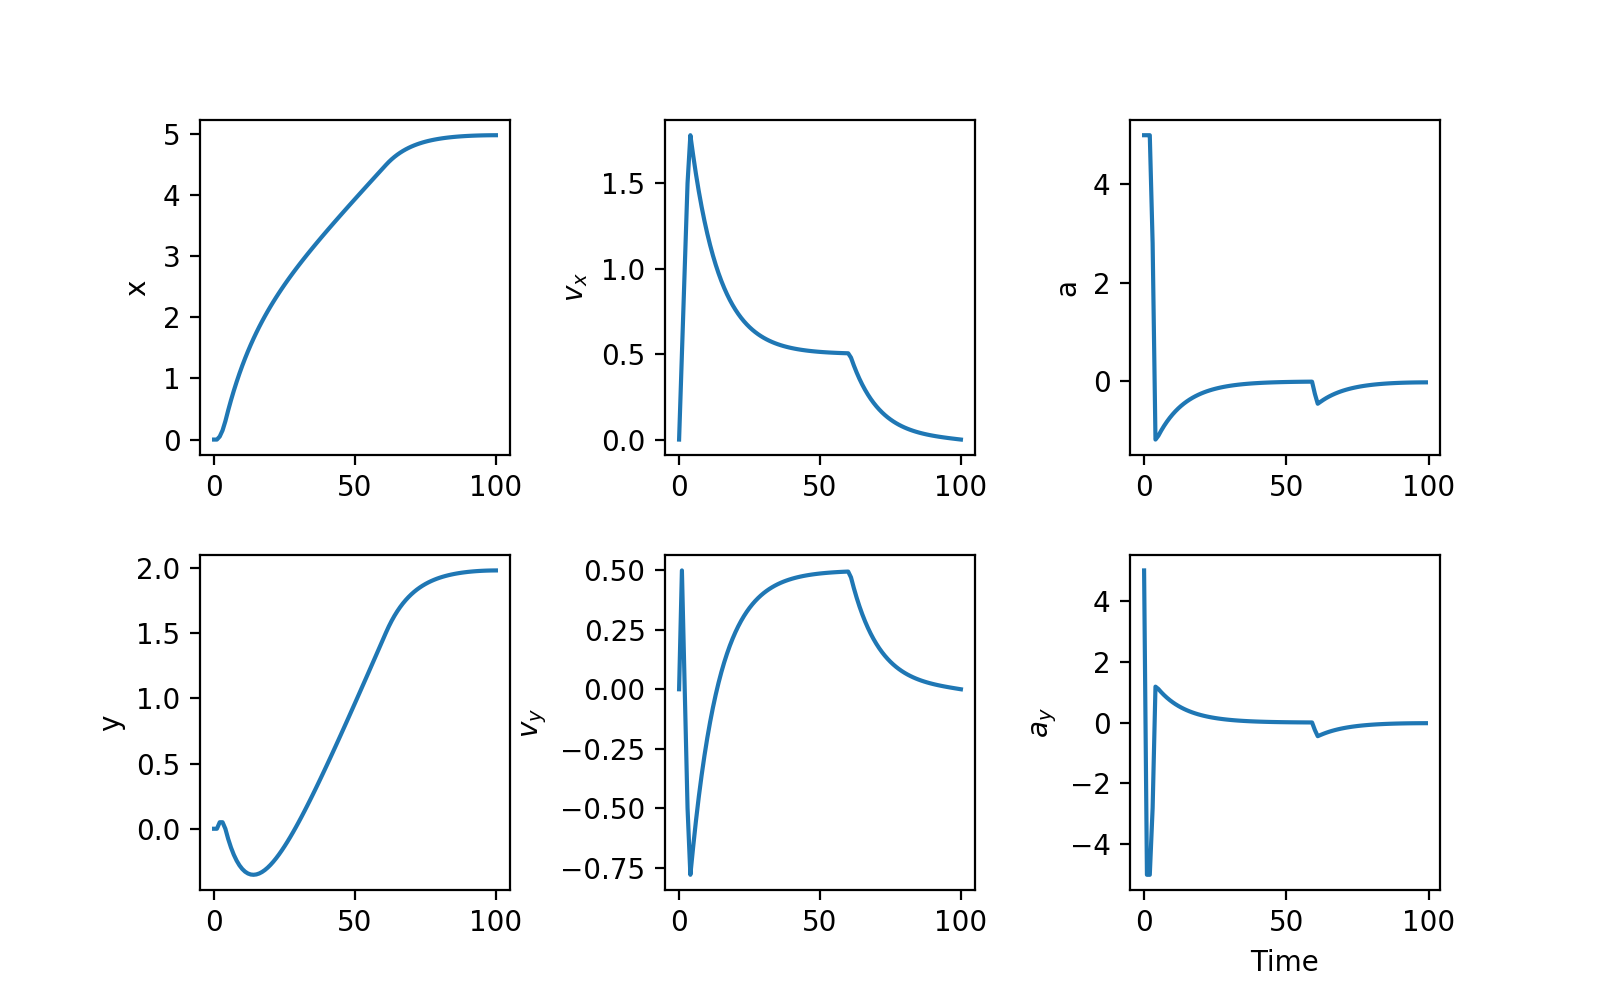

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAzfG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAARUGWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAAADADo2G98f8mU66joAAAMAB6gB
TAFKAhzn/w819xKfRBpZpsc5jvpRT+AD1Mb3QAzA1AtnA9BH4dIGZOIWBKDdx+XYE/Mc2VpnjOME
1bLOjIRBi/9XPIJIO//6sF/9SdKgpMpby2Am2qnx/b7k/jzCJTsds8/YK5wi4lV9V+6Lyl1lFBPw
a5Fep05dsNAk8WXE4j2YufyYFoHL+6ypE/kDQ6ek0EXMRj+6fRNi+Dd20/Sk/5m+k6LxWWueZJwG
cLruPjZLchMmabdEYCrEmPmhbtDzTgwxZD14xYMmci+yBKuvEFh2CtUHI/h6xON/FzO/1u8zc//+
KfJ4OUJ0LTBPTsIRbVh2e+WYAaTz/6WaOTCd0yevC0ykjB1CKQcmdr0QzS8qPOtF/liqA8Rq902E
rL9AoUVOHcwWnBkWTSNEwt59z+cUMakW6Mk/uTazmgIZX+pRArE0ZgUlQf1+fD2t+NDZoAoKPfGn
8YZUKWq9Wq+pFmCk9R0ArUICpMXL5LIicltL9PrAEw2i/MEvq3/NvU5nj4nAaTgRqs1QvuK74GSv
Xl+Xl9oE2kKeTKuvP/FiqglWnSCiCKHSJgpvkhYZzDSLDGTV53RXjxCP/qVRs1nMGN1N6bOzP4jK
g8w2ARUdfmzCvRLYa1llqvbG3BeW32BxP55S8Rz6Acs7EphdujmiCJtLneliedmAgKZVy4u8NfDe
xx7V+668INO1VNof+yIuPfT1NQ6FrLTUp9k9uMWYWTJRX67XNZhbBBIriqU/3pZhdu4/PVloinzH
cDLbA53NkbAwGHOVAAADAAADAAANQAE/nPAEBCB+YGNUczFTlEr2OugZaQjx02Ch3iiUB/b8fNXh
YTkMd9M4cy5yulJsNXcZTqfpZSUvWmoYU0D/8VXQeNqDS+yt/liH3sZLUih0IoIxF35Ar4ZqvEEW
sFt8Z2/B4HFSqafitSKcUpkpM/NK1CY2kJFP1LK+45LB7wAXPo0VGTBi0wsTliZXQ5SN1+97ryu3
JUO887XYtqPzTw5djTjQD1jWtaD/nHADWl5QH0URyuYCkxM1ptfQfPz7HVtbpaKfa2UJwmwRbxHF
S5+7/ssTiPMe/rQ3/nYCRwh2QiN0A1ryw+uebGZhP7B/sMPckzT5cagwUFfCjEt+5iVKX0URyuRJ
Hk0TiNtmYMtau6JFkK2wZJwmwZi+toKL/qv345t+cjxiGXHu6x1iyUAdjwMQ6fmf8+XIqsS6WmSx
40LQVAb46/Iy4IWMb6Sdhm4w/G1CdyXJ1p42x3lVtyGD1L7a65HfaGHOaBBu4AzbQ5+YXCNq3hyH
1zY6cYL3/Q4eAPAy6kCQEdw4gAAACfiOwFSac16ADMNp1xL1SLgApBOuVCPTzjTgBhV5Fmm0L4OG
/tBkuGWCw4s+ecpCvJTKTvYSlOPuPG/u0iVhwz/h02HEA8XFrDyPe7ffo7Fq7gh60LHNVg2NyR2G
9CST+kxuGYF1gbVTyy+QNzFQFpM8/SaJYfqKtlZJtxg4G4WUU5ho0PL+1HdGkxfDKtDoExrvMLnO
542Iy6RVk4qSHlSmlXqD8NmypgELrien5eSqdXzy+ao7tnlrgI59ATkDrHghXzqh4hy2cf2hGAct
rMIGvysKJCUQRXGw7fN/ayWe6EPCoH4YgZLb46A+b2YqwU0qYML8vkd0jzYd3EBbgOg4NdCmEKQn
FGeUEkR8f3s7is2FlKhiqwb4XtakjNR5kIzzsaLIUrKzPvLKDDRFvbsXMdX7qqHup4mLhW/FpBU5
iwAhtPHUzIDayixtHhhyZkAQHuLdemfx2ExD4ZKpgAAAAwAAAwFQDFk/4lEIFFSd/wXSJZMOCBby
F4CNvNUaS6tsqJdAM/NCTd2lE1F/kl8hRhP8fD8bCAvN5yCuZQSqj1hqDWY46mB0GEXhxpB7SkCX
/UMVcnCF5OmqT8vu6mqfkAmIwkDYP7dbtRWApaHmfLDrlnDzpgiZ6B7P/ywjw2Ha+QQmS0LgqH4h
CRZEI7G/jd0lT/XKPk9L6HIUYzvp60AXgXpL7fE/dCv/hbncVIu9JgZLVX26ZZ6hlvSo5wvvwQ31
BkeESzlW04fklBef1JE6XlAotauafJMbY9yhxca99jkfXYAgI1uOcTFv7MwMx2jvJSAPf84uROls
VD5+Jp7j0YUX9+d0MYus7bLn0ngZAXlf9u9M1DIW0FnCZXy8Hzpg39sOXL2r3N4r5xyWjFEfRUz0
mB4wEx7jghZCEY9liD/GRCuRZGZIq9icMl+O/254MaaDIFprZB/2hWNhgRrYVC0fZOEewj3jvIEL
s11fatDmcBjzvEZycNmPowKPgND4NfNzSt5L/3E0e84DvlAlhXp2qLTcOr/I+hfxs9cvM9nanN+9
xbWLzQMwEQ8yOhyrceLGzES45BK3QVrwm/F0bjndFSeCt7LcoAPSsUReFMboqTSCJMIyGlc1IlrF
LecflWjG58PD1Ij6dlVp9pEttStE3QbnS2z5ojZjuI4G2cUhu0bStM44pTveVmfM4Ebw/Jzu5yLQ
Ri4WCJoUyHjC/ot7RaIX7oPPsjOwEp+cG2mjEJGH149IshsYf+oyunbu/tKEt3p773P5YF16vc/M
l0bQAAADAXXAAABT7HKdGjGsRYqVM3bxEdGFmEsjuaBLFU0+aZskLd3mAAY6qP+7XVN5XrjfKr2p
TnNC/2pj6G1eR64jJh4cfpdkJZLxGQKBumbBPTVwoC9B1qTgTK/cswfJg+71iTrSakHWNUh4OnB2
iIjsPgfcFf4SJS6bGipBlGRPywd21NAO324lQL11vcSCcIfMzS/X0/pgVlrVht7W7Ligf0919bqE
AX05Was7yoHjYHXizrI2V

In [17]:
def solve_direct_transcription_new(A,B,Q,R,x0,horizon_length, u_max, u_len,x_des):
    """
    Here we want to find the optimal control path using a direct transcription approach

    Inputs:
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    x_des: the desired goal position
    u_max: the maximum acceleration
    horizon_length: the number of steps

    returns: the state and control trajectories
    """
    # the lenght of the state vector for the full trajectory is
    num_states = x0.size * horizon_length
    #  the length of the control vector for the full trajectory is
    num_control = u_len * horizon_length
    #  the total number of variables is
    num_vars = num_states + num_control


    # ######################################################################
    # ###  here you need to construct the problem as a quadratic program ###
    # ######################################################################
    # ## P: num_vars * num_vars will contain the cost quadratic term
    # ## q: num_vars * 1 will contain the cost linear term
    # ## G: will contain the inequality contraints (max acceleration)
    # ## h: will contain the max and min acceleration
    # ## A and b: will contain the equality constraints associtated to the system dynamics
    Qt = np.zeros([num_vars, num_vars])
    At = np.zeros([num_states, num_vars])
    bt = np.zeros([num_states])
    bt[0:x0.size] = -A.dot(x0)

    qt = np.zeros([num_vars])
    for i in range(horizon_length):
        Qt[x0.size * i:x0.size * (i + 1), x0.size * i:x0.size * (i + 1)] = Q
        Qt[num_states + u_len * i:num_states + u_len * (i + 1),
        num_states + u_len * i:num_states + u_len * (i + 1)] = R

        qt[i * x0.size:(i + 1) * x0.size] = -x_des[:, i].dot(Q)
        At[x0.size * i:x0.size * (i + 1), num_states + u_len * i:num_states + u_len * (i + 1)] = B

        if i > 0:
            At[x0.size * i:x0.size * (i + 1), x0.size * (i - 1):x0.size * (i + 1)] = \
                np.hstack((A, -np.eye(x0.size)))
        # print(P.shape,q.shape)
        else:
            At[x0.size * i:x0.size * (i + 1), x0.size * i:x0.size * (i + 1)] = -np.eye(x0.size)
    P=cvxopt.matrix(Qt)
    q=cvxopt.matrix(qt)

    # max acceleration and velocity constraint
    G1=np.zeros([2*num_control,num_vars])
    G1[:,num_states:]=np.vstack((np.eye(u_len*horizon_length),-np.eye(u_len*horizon_length)))
    h1=np.vstack((np.tile(u_max,u_len*horizon_length),np.tile(u_max,u_len*horizon_length))).flatten()
    G2=np.zeros([horizon_length,num_vars])
    for i in range(horizon_length):
        G2[i,x0.size*i:x0.size*(i+1)] = np.array([0.,1.,0.,1.])
    h2 = np.ones((horizon_length,1)).flatten()
    h = np.hstack((h2,h1)).flatten()
    G = np.vstack((G2,G1))
    
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    
    A=cvxopt.matrix(At)
    b=cvxopt.matrix(bt)

    # # once the problem is constructed we can call the solver
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    x = np.array(sol['x'])

    ## we assume that the problem was constructed with the states first (x0,x1,...)
    ## and then the control inputs (u0, u1, ...)

    # we extract the control trajectory as a 2 * horizon_length array
    u = (x[num_states:].reshape(horizon_length, 2)).transpose()

    # we extract the state trajectory and add the initial condition
    x = x[0:num_states]
    x = np.vstack((x0, x.reshape([horizon_length, x0.size]))).transpose()

    return x, u

u_max = 5.
dt = 0.1
horizon_length = 100

Q = np.array([[1000., 0., 0., 0.], [0., 1000., 0., 0.], [0., 0., 1000., 0.], [0., 0., 0., 1000.]])
R = np.array([[0.1, 0.], [0., 0.1]])

x0 = np.array([0.,0.,0.,0.])

A = np.array([[1., dt, 0., 0.], [0, 1., 0, 0], [0, 0, 1, dt], [0., 0., 0, 1]])
B = np.array([[0., 0], [dt, 0.], [0, 0], [0., dt]])

u_len = 2
x_des = np.tile(np.array([[5.],[0.],[2.],[0.]]),horizon_length)

x,u = solve_direct_transcription_new(A,B,Q,R,x0,horizon_length, u_max, u_len,x_des)
# print(x,u)
animate_car(x, (5,2))

plt.figure(figsize=(8,5))
plt.subplots_adjust(wspace =0.5, hspace =0.3)
plt.subplot(2,3,1)
plt.plot(x[0,:])
plt.ylabel('x')
plt.subplot(2,3,2)
plt.plot(x[1,:])
plt.ylabel('$v_x$')
plt.subplot(2,3,3)
plt.plot(u[0,:])
plt.ylabel('a')
plt.subplot(2,3,4)
plt.plot(x[2,:])
plt.ylabel('y')
plt.subplot(2,3,5)
plt.plot(x[3,:])
plt.ylabel(r'$v_y$')
plt.subplot(2,3,6)
plt.plot(u[1,:])
plt.ylabel(r'$a_y$')
plt.xlabel('Time')
animate_car(x,(5,2)) 
